In [10]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json
import einops
from collections import defaultdict

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder
from notebooks.eval_care_retrieval import load_model, load_data
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

In [2]:
model_paths = {
    "Tarsier (Base Model)": "/work/piyush/pretrained_checkpoints/Tarsier-7b",
    "TARA (Ours)": "/work/piyush/pretrained_checkpoints/TARA",
}
device_map = "auto"
attn_implementation = 'flash_attention_2'

models = {}
for key, model_path in model_paths.items():
    model = AutoEncoder.from_pretrained(
        model_path,
        device_map=device_map,
        attn_implementation=attn_implementation,
        use_flash_attn=False,
        dtype=torch.bfloat16,
    )
    models[key] = model
    su.misc.num_params(model.model)
    print("-" * 120)
len(models)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
------------------------------------------------------------------------------------------------------------------------
Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/TARA
### do_image_padding is set as False, images will be resized directly!


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
------------------------------------------------------------------------------------------------------------------------


2

In [12]:
# Load data

dataset = 'ssv2'
label_col = 'template'

# dataset = 'epic'
# label_col = 'narration'

df = load_data(dataset)
df = df.drop_duplicates(subset=['id', 'text_id']).reset_index(drop=True)

# Chiral IDs
chiral_triplet_ids = df.chiral_triplet_id.unique()
len(chiral_triplet_ids)

Number of rows:  1430
Sample row: 
{
    "id": 69703,
    "label": "moving pen up",
    "template": "Moving [something] up",
    "placeholders": "['pen']",
    "target": 114,
    "chiral_label": 0.0,
    "chiral_triplet_id": "3f20f09b",
    "noun": "['something']",
    "text_id": "3f20f09b_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/69703.webm"
}


16

### Extracting top K tokens

In [4]:
def extract_topk_tokens(model, frames_raw, k=25):
    with torch.no_grad():
        zv = model.encode_vision(frames_raw.unsqueeze(0))
        logits = model.model.language_model.lm_head(zv).cpu().float().squeeze(0)

    # Pick up top-K tokens to look at and their logit values
    topk = torch.topk(logits, k=k, dim=-1)
    topk_values = topk.values
    topk_indices = topk.indices

    # Decode into strings
    token_strings = [model.processor.tokenizer.decode([t], skip_special_tokens=False) for t in topk_indices]

    return token_strings, topk_values

In [5]:
# i = 0
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()

video_path = row['video_path']
frames_raw = read_frames_decord(video_path, 8)
tokens, logits = extract_topk_tokens(models['TARA (Ours)'], frames_raw)

print(np.array(tokens))
print(logits)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


['fol' 'F' 'unfold' 'making' 'orig' 'P' 'paper' 'hands' 'fold' 'manip' 'H'
 'b' 'wrapping' 'demonstr' 'two' 'sh' 'Un' 'hand' 'folder' 'person' 'M'
 'make' 'fingers' 'Orig' 'B']
tensor([19.7500, 16.5000, 15.9375, 14.6875, 14.3750, 14.3125, 14.1250, 13.6250,
        12.0000, 11.6875, 11.6875, 11.3750, 11.1250, 10.6250, 10.5625, 10.5625,
        10.2500, 10.1250, 10.0000, 10.0000, 10.0000,  9.7500,  9.7500,  9.5625,
         9.5000])


### Qualitative: Visualize top K tokens for base and tuned model avg across many samples in chiral pair

In [ ]:
cid = np.random.choice(chiral_triplet_ids)
subdf = df[df.chiral_triplet_id == cid]
subdf.shape, subdf[label_col].unique()

((321, 10),
 array(['Folding [something]', 'Unfolding [something]'], dtype=object))

In [29]:
labels = subdf[label_col].unique()
avg_logits = {}
for l in labels:
    avg_logits[l] = defaultdict(list)
    subsubdf = subdf[subdf[label_col] == l]
    for j in su.log.tqdm_iterator(range(len(subsubdf)), desc=f'Computing logits for {l}'):
        row = subsubdf.iloc[j].to_dict()
        video_path = row['video_path']
        frames_raw = read_frames_decord(video_path, 8)

        for k in models:
            model = models[k]
            with torch.no_grad():
                zv = model.encode_vision(frames_raw.unsqueeze(0))
                logits = model.model.language_model.lm_head(zv).cpu().float().squeeze(0)
            avg_logits[l][k].append(logits)

len(avg_logits)

Computing logits for Closing [something]:   0%|          | 0/12 [00:00<?, ?it/s]

Computing logits for Opening [something]:   0%|          | 0/19 [00:00<?, ?it/s]

2

In [30]:
models.keys(), avg_logits.keys()

(dict_keys(['Tarsier (Base Model)', 'TARA (Ours)']),
 dict_keys(['Closing [something]', 'Opening [something]']))

In [33]:
def get_topk_tokens_from_logits(logits, k=25):
    # Pick up top-K tokens to look at and their logit values
    topk = torch.topk(logits, k=k, dim=-1)
    topk_values = topk.values
    topk_indices = topk.indices

    # Decode into strings
    token_strings = [model.processor.tokenizer.decode([t], skip_special_tokens=False) for t in topk_indices]

    return token_strings, topk_values

In [48]:
def plot_logits(token_strings, values, ax, cmap=None, label_fontsize=10):
    """
    Plot vertical bars for token logits, place token labels inside bars,
    and color bars according to logit magnitude (darker = larger).
    
    Args:
        token_strings: list of str, labels for each bar (same order as values)
        values: array-like or torch.Tensor of shape (K,)
        ax: matplotlib Axes to draw on
        cmap: matplotlib colormap (optional). Defaults to plt.cm.Blues.
        label_fontsize: int font size for labels placed inside bars
    Returns:
        bars: BarContainer from ax.bar
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if cmap is None:
        cmap = plt.cm.Blues

    # --- Normalize values, accepting torch.Tensor or numpy/list ---
    try:
        # if torch is available and it's a tensor, convert safely
        import torch
        if isinstance(values, torch.Tensor):
            vals = values.detach().cpu().numpy()
        else:
            vals = np.asarray(values)
    except Exception:
        vals = np.asarray(values)

    vals = np.array(vals, dtype=float).ravel()
    if vals.size != len(token_strings):
        raise ValueError("length of token_strings must match length of values")

    # --- Color mapping (higher -> darker) ---
    vmin = float(vals.min())
    vmax = float(vals.max())
    denom = (vmax - vmin) if (vmax != vmin) else 1.0
    norm = (vals - vmin) / denom  # in [0,1]
    # map norm to colormap range (avoid the very pale end)
    color_values = [cmap(0.25 + 0.75 * n) for n in norm]

    # --- Draw bars ---
    x = np.arange(len(token_strings))
    bars = ax.bar(x, vals, color=color_values, edgecolor='none')

    # axes labels + grid
    # ax.set_xlabel("Token")
    # ax.set_ylabel("Logit Value")
    ax.grid(axis="y", alpha=0.4)

    # remove crowded x-ticks; we'll draw labels inside bars instead
    ax.set_xticks([])

    # --- Put token labels inside each bar ---
    for i, (bar, tok, n) in enumerate(zip(bars, token_strings, norm)):
        height = bar.get_height()
        # Choose readable text color depending on darkness (norm)
        text_color = "white" if n > 0.55 else "black"
        # place text centered horizontally, at ~50% of the bar height
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            max(0.02 * (vmax - vmin), height * 0.5),  # small floor so very small bars still show label
            tok,
            ha="center",
            va="center",
            rotation=90,            # rotate to match your example
            fontsize=label_fontsize,
            color=text_color,
            clip_on=True,
        )

    # tighten layout so labels aren't clipped
    ax.figure.tight_layout()
    return bars

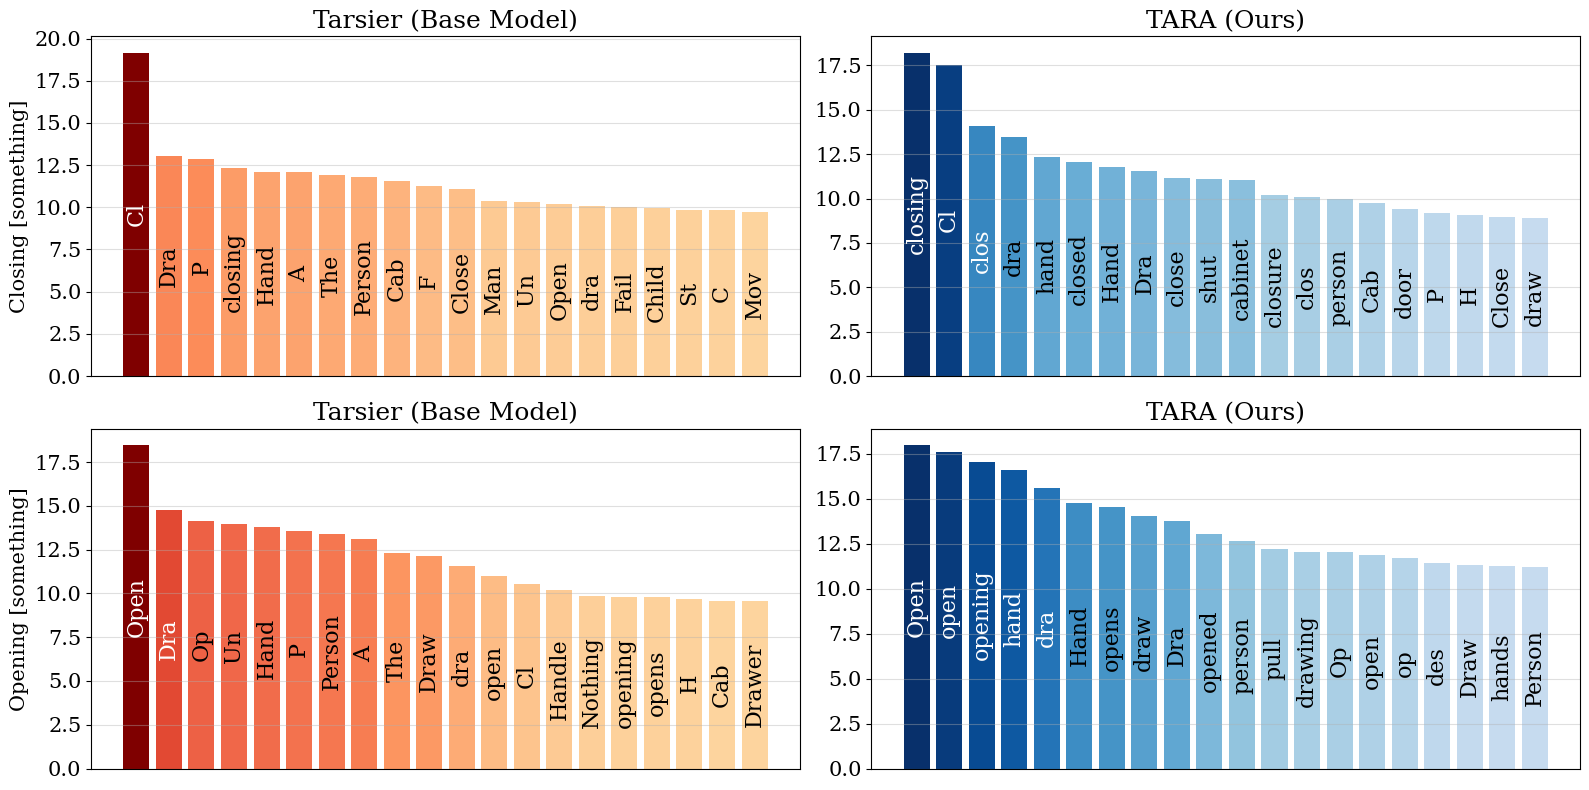

In [55]:
fig, axes = plt.subplots(len(labels), len(models), figsize=(16, 8))
save = False

for p, l in enumerate(labels):
    for q, k in enumerate(list(models.keys())):
        z = torch.stack(avg_logits[l][k]).mean(dim=0)
        tokens, values = get_topk_tokens_from_logits(z, k=20)
        tokens = np.array(tokens)
        # print(l, k, z.shape)
        ax = axes[p][q]
        if q == 0:
            ax.set_ylabel(l)
        else:
            ax.set_ylabel(None)
        ax.set_title(k)

        cmap_ = plt.cm.OrRd if q == 0 else plt.cm.Blues
        plot_logits(tokens, values, ax, cmap=cmap_, label_fontsize=16)
        su.visualize.increase_font_sizes(ax, 1.5)

plt.tight_layout()
if save:
    plt.savefig(f'../figures/avg_logits_{cid}-v1.pdf', bbox_inches='tight')
plt.show()

### Qualitative: Visualize top K tokens for base and tuned model for a single sample

In [5]:



# i = np.random.randint(len(df))
# row = df.iloc[i].to_dict()
# row

# video_path = row['video_path']
# frames_raw = read_frames_decord(video_path, 8)
# tokens_base, logits_base = extract_topk_tokens(model_base, frames_raw)
# tokens_fine, logits_fine = extract_topk_tokens(model_fine, frames_raw)

# fig, axes = plt.subplots(3, 1, figsize=(14, 6))
# canvas = su.visualize.concat_images_with_border(
#     [PIL.Image.fromarray(f.numpy()) for f in frames_raw.permute((0, 2, 3, 1))]
# )
# ax = axes[0]
# ax.imshow(canvas)
# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])
# ax.set_title("Input video with caption: %s" % row[label_col])

# ax = axes[1]
# plot_logits(tokens_base, logits_base, ax, cmap=plt.cm.OrRd)
# ax.set_title("Base model")

# ax = axes[2]
# plot_logits(tokens_fine, logits_fine, ax, cmap=plt.cm.Blues)
# ax.set_title("TARA")

# plt.tight_layout()
# plt.show()

### Quantitative

In [6]:
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()
row

video_path = row['video_path']
frames_raw = read_frames_decord(video_path, 8)
tokens, logits = extract_topk_tokens(model, frames_raw)
tokens, logits

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


(['fol',
  'F',
  'hands',
  'person',
  'H',
  'unfold',
  'two',
  'white',
  'paper',
  'folder',
  'hand',
  'man',
  'wrapping',
  'f',
  'sheet',
  'manip',
  'fold',
  'handling',
  'manipulate',
  'making',
  'b',
  'tw',
  'Person',
  'Two',
  'P'],
 tensor([23.2500, 17.7500, 14.0000, 13.6875, 13.0625, 12.8125, 12.3750, 12.3125,
         12.1250, 11.8125, 11.6250, 11.6250, 11.5000, 11.1875, 10.9375, 10.8750,
         10.8125, 10.6875, 10.3125, 10.3125, 10.2500, 10.0625, 10.0625, 10.0625,
         10.0625]))

In [7]:
import numpy as np
import torch
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

class SemanticMRREvaluator:
    def __init__(self, model_name: str = "/work/piyush/pretrained_checkpoints/all-MiniLM-L6-v2"):
        """
        Initialize with a lightweight sentence embedding model.
        
        Args:
            model_name: HuggingFace model name. Options:
                - "sentence-transformers/all-MiniLM-L6-v2" (lightweight, 80MB)
                - "sentence-transformers/all-mpnet-base-v2" (better quality, 420MB)
        """
        print(f"Loading embedding model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()
        
        # Use GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
    
    def get_embedding(self, text: str) -> np.ndarray:
        """Get embedding for a single text."""
        # Tokenize
        encoded = self.tokenizer(
            text, 
            padding=True, 
            truncation=True, 
            return_tensors="pt"
        ).to(self.device)
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**encoded)
            # Mean pooling
            embeddings = self.mean_pooling(outputs, encoded['attention_mask'])
            # Normalize
            embeddings = F.normalize(embeddings, p=2, dim=1)
        
        return embeddings.cpu().numpy()[0]
    
    def mean_pooling(self, model_output, attention_mask):
        """Mean pooling - take average of all token embeddings."""
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def compute_similarity(self, text1: str, text2: str) -> float:
        """Compute cosine similarity between two texts."""
        emb1 = self.get_embedding(text1)
        emb2 = self.get_embedding(text2)
        return np.dot(emb1, emb2)  # Already normalized, so dot product = cosine similarity
    
    def compute_mrr(self, 
                    top_k_tokens: List[str], 
                    ground_truth_verb: str,
                    similarity_threshold: float = 0.5) -> Tuple[float, List[Tuple[int, str, float]]]:
        """
        Compute MRR using semantic similarity.
        
        Args:
            top_k_tokens: List of K tokens sorted by logits (highest first)
            ground_truth_verb: The ground truth verb to match against
            similarity_threshold: Minimum cosine similarity to consider a match (0-1)
            
        Returns:
            Tuple of (mrr_score, matches) where matches is list of (rank, token, similarity)
        """
        # Get embedding for ground truth verb
        gt_embedding = self.get_embedding(ground_truth_verb)
        
        matches = []
        first_match_rank = None
        
        # Check each token in order
        for rank, token in enumerate(top_k_tokens, start=1):
            # Get token embedding and compute similarity
            token_embedding = self.get_embedding(token)
            similarity = np.dot(gt_embedding, token_embedding)
            
            # Record if it's above threshold
            if similarity >= similarity_threshold:
                matches.append((rank, token, float(similarity)))
                if first_match_rank is None:
                    first_match_rank = rank
        
        # Compute MRR
        mrr = 1.0 / first_match_rank if first_match_rank else 0.0
        
        return mrr, matches
    
    def compute_mrr_batch(self,
                         top_k_tokens: List[str],
                         ground_truth_verb: str,
                         similarity_threshold: float = 0.5) -> Tuple[float, List[Tuple[int, str, float]]]:
        """
        Optimized version: compute all similarities in one batch.
        Much faster for large K.
        """
        if len(top_k_tokens) == 0:
            return 0.0, []
        
        # Get all embeddings in batch
        gt_embedding = self.get_embedding(ground_truth_verb)
        
        # Batch encode all tokens
        encoded = self.tokenizer(
            top_k_tokens,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**encoded)
            embeddings = self.mean_pooling(outputs, encoded['attention_mask'])
            embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute similarities
        gt_tensor = torch.tensor(gt_embedding).to(self.device)
        similarities = torch.matmul(embeddings, gt_tensor).cpu().numpy()
        
        # Find matches
        matches = []
        first_match_rank = None
        
        for rank, (token, similarity) in enumerate(zip(top_k_tokens, similarities), start=1):
            if similarity >= similarity_threshold:
                matches.append((rank, token, float(similarity)))
                if first_match_rank is None:
                    first_match_rank = rank
        
        mrr = 1.0 / first_match_rank if first_match_rank else 0.0
        
        return mrr, matches


# ============ USAGE EXAMPLE ============

def example_usage():
    # Initialize evaluator
    evaluator = SemanticMRREvaluator()
    
    # Example: Single video evaluation
    print("\n" + "="*70)
    print("EXAMPLE 1: Single prediction")
    print("="*70)
    
    ground_truth_verb = "put"
    top_k_tokens = ["person", "hand", "placing", "kitchen", "cover", "setting", "lid"]
    
    mrr, matches = evaluator.compute_mrr_batch(
        top_k_tokens=top_k_tokens,
        ground_truth_verb=ground_truth_verb,
        similarity_threshold=0.5
    )
    
    print(f"\nGround truth verb: '{ground_truth_verb}'")
    print(f"Top-K tokens: {top_k_tokens}")
    print(f"\nMatches (similarity >= 0.5):")
    for rank, token, sim in matches:
        print(f"  Rank {rank}: '{token}' (similarity: {sim:.3f})")
    print(f"\nMRR: {mrr:.4f}")
    if mrr > 0:
        print(f"First match at rank: {int(1/mrr)}")
    
    # Example: Compare two models
    print("\n" + "="*70)
    print("EXAMPLE 2: Model comparison on dataset")
    print("="*70)
    
    # Dataset: list of (top_k_tokens, ground_truth_verb)
    dataset = [
        (["person", "hand", "placing", "kitchen", "cover"], "put"),
        (["walking", "person", "moving", "going"], "walk"),
        (["opening", "door", "person", "unlocking"], "open"),
        (["cutting", "knife", "slicing", "chopping"], "cut"),
    ]
    
    # Model A predictions (top-K tokens for each video)
    model_a_predictions = [
        ["person", "hand", "placing", "kitchen", "cover"],
        ["person", "walking", "moving", "going"],
        ["door", "person", "opening", "unlocking"],
        ["knife", "person", "slicing", "cutting"],
    ]
    
    # Model B predictions
    model_b_predictions = [
        ["placing", "person", "hand", "kitchen", "cover"],
        ["walking", "person", "moving", "going"],
        ["opening", "door", "person", "unlocking"],
        ["cutting", "knife", "slicing", "chopping"],
    ]
    
    # Evaluate both models
    mrr_scores_a = []
    mrr_scores_b = []
    
    for i, (_, gt_verb) in enumerate(dataset):
        mrr_a, _ = evaluator.compute_mrr_batch(model_a_predictions[i], gt_verb)
        mrr_b, _ = evaluator.compute_mrr_batch(model_b_predictions[i], gt_verb)
        mrr_scores_a.append(mrr_a)
        mrr_scores_b.append(mrr_b)
    
    avg_mrr_a = np.mean(mrr_scores_a)
    avg_mrr_b = np.mean(mrr_scores_b)
    
    print(f"\nModel A - MRR: {avg_mrr_a:.4f}")
    print(f"Model B - MRR: {avg_mrr_b:.4f}")
    print(f"Improvement: {((avg_mrr_b - avg_mrr_a) / avg_mrr_a * 100):.2f}%")
    
    # Show per-sample breakdown
    print("\nPer-sample results:")
    print(f"{'Video':<10} {'GT Verb':<10} {'Model A':<10} {'Model B':<10}")
    print("-" * 45)
    for i, (_, gt_verb) in enumerate(dataset):
        print(f"{i+1:<10} {gt_verb:<10} {mrr_scores_a[i]:.4f}     {mrr_scores_b[i]:.4f}")


# ============ ADDITIONAL UTILITIES ============

def analyze_similarity_threshold(evaluator: SemanticMRREvaluator,
                                top_k_tokens: List[str],
                                ground_truth_verb: str):
    """
    Helper to determine appropriate similarity threshold.
    """
    print(f"\nAnalyzing thresholds for verb: '{ground_truth_verb}'")
    print(f"Tokens: {top_k_tokens}\n")
    
    # Compute similarities for all tokens
    gt_embedding = evaluator.get_embedding(ground_truth_verb)
    
    similarities = []
    for token in top_k_tokens:
        token_embedding = evaluator.get_embedding(token)
        sim = np.dot(gt_embedding, token_embedding)
        similarities.append((token, sim))
    
    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Token':<20} {'Similarity':<12} {'Match?'}")
    print("-" * 50)
    for token, sim in similarities:
        match_05 = "✓" if sim >= 0.5 else ""
        match_06 = "✓" if sim >= 0.6 else ""
        print(f"{token:<20} {sim:.4f}       @0.5:{match_05:<3} @0.6:{match_06}")


if __name__ == "__main__":
    example_usage()
    
    # Optional: analyze what threshold works best
    print("\n" + "="*70)
    print("THRESHOLD ANALYSIS")
    print("="*70)
    evaluator = SemanticMRREvaluator()
    analyze_similarity_threshold(
        evaluator,
        ["person", "hand", "placing", "kitchen", "cover", "setting", "random"],
        "put"
    )

Loading embedding model: /work/piyush/pretrained_checkpoints/all-MiniLM-L6-v2

EXAMPLE 1: Single prediction

Ground truth verb: 'put'
Top-K tokens: ['person', 'hand', 'placing', 'kitchen', 'cover', 'setting', 'lid']

Matches (similarity >= 0.5):

MRR: 0.0000

EXAMPLE 2: Model comparison on dataset

Model A - MRR: 0.4583
Model B - MRR: 0.7500
Improvement: 63.64%

Per-sample results:
Video      GT Verb    Model A    Model B   
---------------------------------------------
1          put        0.0000     0.0000
2          walk       0.5000     1.0000
3          open       0.3333     1.0000
4          cut        1.0000     1.0000

THRESHOLD ANALYSIS
Loading embedding model: /work/piyush/pretrained_checkpoints/all-MiniLM-L6-v2

Analyzing thresholds for verb: 'put'
Tokens: ['person', 'hand', 'placing', 'kitchen', 'cover', 'setting', 'random']

Token                Similarity   Match?
--------------------------------------------------
placing              0.3883       @0.5:    @0.6:
random  

In [14]:
mrr, matches = evaluator.compute_mrr_batch(
    top_k_tokens=tokens,
    ground_truth_verb=row['template'],
    similarity_threshold=0.4
)

In [15]:
mrr, matches

(0.16666666666666666,
 [(6, 'unfold', 0.5344040989875793),
  (13, 'wrapping', 0.4734230041503906),
  (17, 'fold', 0.8010359406471252)])

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /users/piyush/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/piyush/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /users/piyush/nltk_data...
[nltk_data] Downloading package omw-1.4 to /users/piyush/nltk_data...


True

In [8]:
from notebooks.utils_logits import *

In [9]:
row

{'id': 171877,
 'label': 'putting pencil',
 'template': 'Putting [something similar to other things that are already on the table]',
 'placeholders': "['pencil']",
 'target': 18,
 'chiral_label': 1.0,
 'chiral_triplet_id': 'b58b2f93',
 'noun': "['something']",
 'text_id': 'b58b2f93_1.0',
 'video_path': '/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/171877.webm'}

In [12]:
generate_verb_candidates_from_caption_nltk(row['label'])

LookupError: Missing NLTK resources: ['wordnet', 'omw-1.4']. Run in Python:
import nltk
nltk.download(['wordnet', 'omw-1.4'])
(e.g. nltk.download('punkt'); nltk.download('averaged_perceptron_tagger'); nltk.download('wordnet'); nltk.download('omw-1.4'))

In [11]:
import nltk
nltk.download(['wordnet', 'omw-1.4'])

[nltk_data] Downloading package wordnet to /users/piyush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /users/piyush/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True